# Importing Modules and Loading Dataset

In [1]:
import chess
import numpy as np
import pandas as pd
import tensorflow as tf
import math
# We import the following modules

The path here is the path where the dataset is located.  
We take in all the data from the file.  
Our dataset contains the chess position in FEN notation and the corresponding Stockfish 22 Evaluation

In [2]:
abs_path="d:\OneDrive - Indian Institute of Technology Bombay\Study\Events and Activities\Year 2\Seasons of Coding 23\soc23-DeepCarlsen"
TotalPos = pd.read_csv(abs_path+"\dataset\chessDataEval.csv", )
TotalPos

,FEN,Evaluation
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-10
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,+56
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,-9
3,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...,+52
4,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...,-26
...,...,...
12958030,r1bqkb1r/pp3ppp/1nn1p3/3pP3/3P1P2/1B3N2/PP2Q1P...,+6
12958031,r2qkb1r/pp1b1ppp/1nn1p3/3pP3/3P1P2/1B3N2/PP2Q1...,+84
12958032,r2qkb1r/pp1b1ppp/1nn1p3/3pP3/3P1P2/1BN2N2/PP2Q...,0
12958033,r2qkb1r/pp1b1ppp/1n2p3/n2pP3/3P1P2/1BN2N2/PP2Q...,+115


In [3]:
def cond(arr):
    pos = arr["FEN"].split()[0]
    res = pos.count('Q')>1 or pos.count('B')>2 or pos.count('N')>2 or pos.count('R')>2 or pos.count('q')>1 or pos.count('b')>2 or pos.count('n')>2 or pos.count('r')>2
    return not res
dataset_raw = TotalPos[TotalPos.apply(cond, axis = 1)]

Our model is not equipped to deal with positions with number of pieces exceeding the beginning like 2 queens, 5 bishops, etc  
Hence the cond function filters all such positions

In [4]:
dataset = dataset_raw.sample(100000)    #Due to slow processing Power we only take in a hundred thousand samples and then re index all of them
dataset.reset_index(inplace=True)
dataset = dataset.drop(["index"], axis=1)
dataset

,FEN,Evaluation
0,2r1r1k1/1R2Bp1p/4b1p1/4b3/8/1Pq2B2/2P3PP/3Q1R1...,+16
1,8/8/1p2R3/pPb3pk/r7/6B1/5PK1/8 w - - 0 48,-139
2,8/6pk/p1p1q1pp/1p2p3/1P2Pn2/2P2P1P/1P1Q2PK/5N2...,+60
3,5rk1/5pp1/pqn1b2p/3pPN2/2p5/2P2Q1P/Pr3PP1/RB1R...,-173
4,r3r1k1/pppq1pp1/2np3p/2b1p3/4Q2N/1P1P3P/1PP2PP...,-346
...,...,...
99995,3r2k1/pp3rp1/1b4Qp/n1p2N2/2q1P3/8/PB3PPP/1B3RK...,+882
99996,r3k2r/1p1bbp2/p2ppp1p/q7/3NP2P/2NQ4/PPP2PP1/1K...,+106
99997,3Q4/5kp1/8/1p1pB2q/2pPn3/2P3PK/1P5P/8 w - - 9 39,0
99998,3r1rk1/p4pp1/1p2b2p/2bB3q/1P2PB2/P1N3P1/3Q1P1K...,+165


In [5]:
#dataset = dataset_raw

# Feature Extraction

In [6]:
def features_global(arr):       #This returns the first set of features consisting of each turn to play, and castling rights still available.
    fen = arr if isinstance(arr, str) else arr["FEN"]
    board = chess.Board(fen)
    white_play = (board.turn==chess.WHITE)
    K = board.has_kingside_castling_rights(chess.WHITE)
    k = board.has_kingside_castling_rights(chess.BLACK)
    Q = board.has_queenside_castling_rights(chess.WHITE)
    q = board.has_queenside_castling_rights(chess.BLACK)
    return [int(white_play),int(K), int(k), int(Q), int(q)]

In [7]:
def features_piece(arr):        # This returns the second set of features consisting of number of each piece type and their respective positions. Captured pieces are just said to be at -1,-1
    def p(symbol):
        return chess.Piece.from_symbol(symbol)
    fen = arr if isinstance(arr, str) else arr["FEN"]
    board = chess.Board(fen)
    pieces_map = chess.Board.piece_map(board)
    emp = [-1,-1]
    piece_num = [0]*14
    piece_w = [emp]*16  # K Q B(light) B(dark) N N R R P P P P P P P P
    piece_b = [emp]*16  # k q b(light) b(dark) n n r r p p p p p p p p
    for (loc, pi) in pieces_map.items():
        if pi== p('k'):
            piece_b[0] = [loc%8,loc//8]
            piece_num[7]+=1
        elif pi== p('q'):
            piece_b[1] = [loc%8,loc//8]
            piece_num[8]+=1
        elif pi== p('b'):
            if((loc%8+loc//8)%2!=0):
                piece_b[2] = [loc%8,loc//8]
                piece_num[9]+=1
            else:
                piece_b[3] = [loc%8,loc//8]
                piece_num[10]+=1
        elif pi== p('n'):
            piece_b[piece_b[4:6].index(emp)+4]=[loc%8,loc//8]
            piece_num[11]+=1
        elif pi== p('r'):
            piece_b[piece_b[6:8].index(emp)+6]=[loc%8,loc//8]
            piece_num[12]+=1
        elif pi== p('p'):
            piece_b[piece_b[8:16].index(emp)+8]=[loc%8,loc//8]
            piece_num[13]+=1

        elif pi== p('K'):
            piece_w[0] = [loc%8,loc//8]
            piece_num[0]+=1
        elif pi== p('Q'):
            piece_w[1] = [loc%8,loc//8]
            piece_num[1]+=1
        elif pi== p('B'):
            if((loc%8+loc//8)%2!=0):
                piece_w[2] = [loc%8,loc//8]
                piece_num[2]+=1
            else:
                piece_w[3] = [loc%8,loc//8]
                piece_num[3]+=1
        elif pi== p('N'):
            piece_w[piece_w[4:6].index(emp)+4]=[loc%8,loc//8]
            piece_num[4]+=1
        elif pi== p('R'):
            piece_w[piece_w[6:8].index(emp)+6]=[loc%8,loc//8]
            piece_num[5]+=1
        elif pi== p('P'):
            piece_w[piece_w[8:16].index(emp)+8]=[loc%8,loc//8]
            piece_num[6]+=1
    result = piece_num+[item for sublist in piece_w for item in sublist]+[item for sublist in piece_b for item in sublist]
    return result


In [8]:
def features_map(arr):      # This returns a set of features giving a general feature map of the position. 
                            #We denote the lowest attacker of each color on each square and number of attackers of a color on each square
    fen = arr if isinstance(arr, str) else arr["FEN"]
    piece_value = {6:1, 5:9, 3:3, 2:3, 4:5, 1:1} #Piece value as used in standard chess games
    #piece_value = {6:0, 5:1340, 3:425, 2:450, 4:680, 1:110}
    board = chess.Board(fen)
    wht = []
    wht_count = []
    blk = []
    blk_count = []
    for sq in chess.SQUARES:   
        attks_white = chess.BaseBoard.attackers(board, chess.WHITE, sq)
        attks_black = chess.BaseBoard.attackers(board, chess.BLACK, sq)
        wht.append(0 if len(attks_white)==0 else min(piece_value[chess.BaseBoard.piece_type_at(board, sq2)] for sq2 in attks_white))
        blk.append(0 if len(attks_black)==0 else min(piece_value[chess.BaseBoard.piece_type_at(board, sq2)] for sq2 in attks_black))
        wht_count.append(len(attks_white))
        blk_count.append(len(attks_black))
    return wht_count+wht+blk_count+blk

In [9]:
def feature_extract(evalPos):           #Thus is the main function which is responsible for extraction of feature space given a dataframe of positions
        feat_centric = evalPos.copy().drop(["FEN", "Evaluation"], axis=1)
        feat_global = evalPos.copy().drop(["FEN", "Evaluation"], axis=1)
        feat_map = evalPos.copy().drop(["FEN", "Evaluation"], axis=1)

        col_centric = [ "cwk", "cwq", "cwbl","cwbd","cwn","cwr","cwp",
                "cbk", "cbq", "cbbl","cbbd","cbn","cbr","cbp", 
                'wk_col', 'wk_row', 'wq_col', 'wq_row', 'wbl_col', 'wbl_row', 'wbd_col', 'wbd_row', 'wn1_col', 'wn1_row', 'wn2_col', 'wn2_row', 'wr1_col', 'wr1_row', 'wr2_col', 'wr2_row',
                 'wp1_col', 'wp1_row', 'wp2_col', 'wp2_row', 'wp3_col', 'wp3_row', 'wp4_col', 'wp4_row', 'wp5_col', 'wp5_row', 'wp6_col', 'wp6_row', 'wp7_col', 'wp7_row', 'wp8_col', 'wp8_row',
                'bk_col', 'bk_row', 'bq_col', 'bq_row', 'bbl_col', 'bbl_row', 'bbd_col', 'bbd_row', 'bn1_col', 'bn1_row', 'bn2_col', 'bn2_row', 'br1_col', 'br1_row', 'br2_col', 'br2_row', 
                'bp1_col', 'bp1_row', 'bp2_col', 'bp2_row', 'bp3_col', 'bp3_row', 'bp4_col', 'bp4_row', 'bp5_col', 'bp5_row', 'bp6_col', 'bp6_row', 'bp7_col', 'bp7_row', 'bp8_col', 'bp8_row']
        col_global = ["white_turn", "castle_wk", "castle_bk", "castle_wq", "castle_bq"]
        col_transfer = ["cwk", "cwq", "cwbl","cwbd","cwn","cwr","cwp",
                        "cbk", "cbq", "cbbl","cbbd","cbn","cbr","cbp"]
        col_map = ["wht_count"+str(i) for i in range(64)]+["wht_attack"+str(i) for i in range(64)]+["blk_count"+str(i) for i in range(64)]+["blk_attack"+str(i) for i in range(64)]
        #col_map = ["wht_count", "wht_attack", "blk_count", "blk_attack"]

        y = evalPos["Evaluation"]

        feat_centric[col_centric] = evalPos[["FEN"]].apply(features_piece, axis=1, result_type="expand")
        feat_global[col_global] = evalPos[["FEN"]].apply(features_global, axis=1, result_type="expand")
        feat_map[col_map] = evalPos[["FEN"]].apply(features_map, axis=1, result_type="expand")

        feat_global = feat_global.join(feat_centric[col_transfer])
        feat_centric.drop(col_transfer, axis=1, inplace=True)
        
        return feat_global, feat_centric, feat_map, y

In [10]:
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)    #We set to ignore some warnings due to the repeated dataframe insertion

In [11]:
feat1, feat2, feat3, y_raw = feature_extract(dataset) #Perform feature extraction on dataset

In [12]:
y_raw
y = y_raw.apply(lambda l: int(l)/10000 if '#' not in l else 1 if '+' in l else -1) #Replace certain mates by +-10000 and then normalize the evaluations
y

0        0.0016
1       -0.0139
2        0.0060
3       -0.0173
4       -0.0346
          ...  
99995    0.0882
99996    0.0106
99997    0.0000
99998    0.0165
99999    0.0232
Name: Evaluation, Length: 100000, dtype: float64

In [13]:
feat3 = np.array(feat3).reshape(len(y), 4, 8, 8) #The feature map should be converted to higher dimentsion numpy array
feat3

array([[[[1, 1, 1, ..., 1, 2, 1],
         [0, 0, 1, ..., 1, 2, 1],
         [1, 2, 0, ..., 3, 1, 1],
         ...,
         [0, 1, 1, ..., 1, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [0, 1, 0, ..., 1, 0, 0]],

        [[9, 9, 9, ..., 9, 1, 5],
         [0, 0, 9, ..., 5, 1, 1],
         [3, 1, 0, ..., 1, 1, 1],
         ...,
         [0, 5, 3, ..., 3, 0, 0],
         [5, 3, 5, ..., 0, 0, 0],
         [0, 5, 0, ..., 3, 0, 0]],

        [[1, 0, 0, ..., 0, 0, 0],
         [0, 1, 1, ..., 0, 0, 1],
         [0, 2, 2, ..., 1, 1, 1],
         ...,
         [0, 0, 2, ..., 1, 2, 0],
         [0, 0, 3, ..., 2, 2, 1],
         [1, 2, 3, ..., 2, 1, 2]],

        [[9, 0, 0, ..., 0, 0, 0],
         [0, 9, 9, ..., 0, 0, 3],
         [0, 3, 3, ..., 9, 3, 3],
         ...,
         [0, 0, 5, ..., 3, 1, 0],
         [0, 0, 3, ..., 1, 1, 1],
         [5, 3, 3, ..., 1, 5, 1]]],


       [[[0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 2, 0, 2],
         [0, 0, 0, ..., 1, 2, 1],
         ...,
  

In [14]:
def tens(arra):
    return tf.convert_to_tensor(np.asarray(arra).astype(np.float_))
nlim = int(len(y)*.8)
(train1, train2, train3, y_train) = (tens(l[:nlim]) for l in [feat1, feat2, feat3, y]) #Convert the feature space to a tensor. Training data and then test data

In [15]:
(test1, test2, test3, y_test) = (tens(l[nlim:]) for l in [feat1, feat2, feat3, y])
test3

<tf.Tensor: shape=(20000, 4, 8, 8), dtype=float64, numpy=
array([[[[2., 2., 1., ..., 3., 1., 1.],
         [1., 1., 3., ..., 2., 1., 1.],
         [2., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 0., 1., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[5., 3., 5., ..., 1., 5., 1.],
         [9., 5., 3., ..., 1., 1., 1.],
         [1., 9., 1., ..., 1., 1., 1.],
         ...,
         [3., 0., 9., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 1., ..., 0., 0., 0.],
         ...,
         [1., 1., 2., ..., 1., 2., 1.],
         [1., 1., 2., ..., 2., 0., 2.],
         [2., 1., 3., ..., 2., 3., 2.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 9., 0., ..., 0., 0., 0.],
         [0., 9., 5., ..., 0., 0., 0.],
         ...,
         [9., 9., 5., ..., 1., 1., 1.],


In [16]:
print(train1.get_shape())
print(train2.get_shape())
print(train3.get_shape())
print(y_train.get_shape())

(80000, 19)
(80000, 64)
(80000, 4, 8, 8)
(80000,)


# Model Creation and Fitting

In [17]:

input1 = tf.keras.Input(shape=(19))
input2 = tf.keras.Input(shape=(64))
input3 = tf.keras.Input(shape=(4,8,8)) #3 input layers

#batch_1 = tf.keras.layers.BatchNormalization()(input1)
batch_2 = tf.keras.layers.BatchNormalization()(input2)
conv1_3 = tf.keras.layers.Conv2D(filters = 5,kernel_size=(3,3), activation=tf.nn.relu)(input3)
flat_3 = tf.keras.layers.Flatten()(conv1_3)

in1_layer = tf.keras.layers.Dense(units=19, activation=tf.nn.relu)(input1)
in2_layer = tf.keras.layers.Dense(units=64, activation=tf.nn.relu)(batch_2)
in3_layer = tf.keras.layers.Dense(units=144, activation=tf.nn.relu)(flat_3)

concat_layer = tf.keras.layers.Concatenate()([in1_layer])#, in2_layer, in3_layer])
batch = tf.keras.layers.BatchNormalization()(concat_layer)
hid1 = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(batch)
hid2 = tf.keras.layers.Dense(units=48, activation=tf.nn.relu)(hid1)
hid3 = tf.keras.layers.Dense(units=96, activation=tf.nn.relu)(hid2)
out = tf.keras.layers.Dense(units=1, activation=tf.nn.tanh)(hid3)

model = tf.keras.Model(inputs=[input1, input2, input3], outputs=out)
model.compile(optimizer=tf.optimizers.Adam(), loss='mse', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 19)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 19)           380         ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 19)           0           ['dense[0][0]']                  
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 19)          76          ['concatenate[0][0]']            
 rmalization)                                                                                 

In [18]:
model.fit(x=[train1, train2, train3], y=y_train, epochs=10) #Perform model fitting,

Epoch 1/10
2500/2500 [==============================] - 12s 3ms/step - loss: 0.0195 - accuracy: 0.0948
Epoch 2/10
2500/2500 [==============================] - 6s 3ms/step - loss: 0.0170 - accuracy: 0.0955
Epoch 3/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.0165 - accuracy: 0.0956
Epoch 4/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.0162 - accuracy: 0.0957
Epoch 5/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.0162 - accuracy: 0.0957
Epoch 6/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.0159 - accuracy: 0.0957
Epoch 7/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.0160 - accuracy: 0.0959
Epoch 8/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.0159 - accuracy: 0.0958
Epoch 9/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.0158 - accuracy: 0.0959
Epoch 10/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.01

In [19]:
y_hat = model.predict(x=[test1, test2, test3])
df = pd.DataFrame({'Actual': y[nlim:]*10000, 'Predicted': y_hat.flatten()*10000})
print(df.describe())
df

625/625 [==============================] - 1s 2ms/step
             Actual     Predicted
count  20000.000000  20000.000000
mean      67.265900     30.977331
std     1413.328257    775.303345
min   -10000.000000  -9873.581055
25%      -74.250000    -58.589892
50%       16.000000     51.666056
75%      146.000000    121.151619
max    10000.000000   9965.929688


,Actual,Predicted
80000,-77.0,-1.993096
80001,735.0,1423.332397
80002,-120.0,-263.944122
80003,0.0,203.462189
80004,-190.0,-46.456669
...,...,...
99995,882.0,9.317022
99996,106.0,121.151619
99997,0.0,467.786713
99998,165.0,633.403870


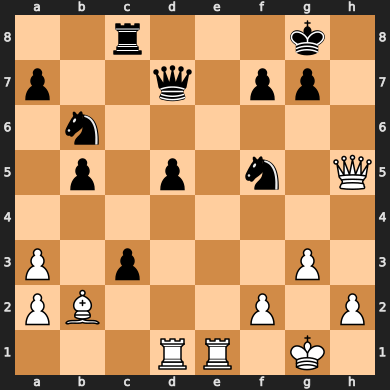

In [20]:
def disp(fen):
    board = chess.Board(fen)
    return board
disp(dataset["FEN"].iloc[80003])

In [21]:
def feat_ex(fen): #function which gives feature space for a single position
    f_centric = features_piece(fen)
    f_global = features_global(fen)
    f_map = features_map(fen)
    f_global.extend(f_centric[:14])
    f_centric=f_centric[14:]
    return [f_global], [f_centric], [f_map]

In [22]:
fe = "2q1rrk1/1b2ppbp/p2p1np1/P1pP4/2B1PP2/2NQ3P/1P1B2P1/R4RK1 w - - 5 22" #testing the evaluation for given position. We can see W has slight advantage
boar = chess.Board(fe)
l1,l2,l3 = feat_ex(fe)
l3 = np.array(l3).reshape(1,4, 8, 8)
(l1,l2,l3) = (tens(l) for l in (l1,l2,l3))
float(model.predict([l1,l2,l3]).flatten())

1/1 [==============================] - 0s 197ms/step


0.005791143048554659

In [29]:
model.save('my_model2',overwrite=True, save_format="tf", save_traces=True) #Attempt to save the model

INFO:tensorflow:Assets written to: my_model2\assets


INFO:tensorflow:Assets written to: my_model2\assets


# Game Play

In [25]:
from chessboard import display
import chess #Procedure to display a chess game

pygame 2.1.2 (SDL 2.0.18, Python 3.10.1)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [61]:
#This code plays a simple game using Pygame. For each position, the game performs simple evaluation for all possible moves.
# Game ends in system exit because else the kernel is restarted as the case when PyGame is run from Jupyter Notebook.

over=False
board = chess.Board()
game_board = display.start()
while(over==False):
    display.check_for_quit()
    mov = input("Move: ").strip()
    try:
        Move = board.parse_san(mov)#chess.Move.from_uci(mov)
    except:
        print("Wrong Move: "+mov)
        continue
    if Move not in board.legal_moves:
        print("RETRY")
        continue
    board.push(Move)
    display.update(board.fen(), game_board)
    if(board.outcome()!=None):
        if(board.outcome().result()=="1-0"):
            print("YOU WIN")
            break
        elif(board.outcome().result()=="0-1"):
            print("YOU LOSE")
            break
        elif(board.outcome().result()=="1/2-1/2"):
            print("DRAW")
            break
    b_move = board.legal_moves
    b_move2 = []
    b_eval =[]
    for m in b_move:
        board.push(m)
        '''
        l1,l2,l3, ly = feature_extract(pd.DataFrame({"FEN": [board.fen()], "Evaluation": [0]}))
        l3 = np.array(l3).reshape(len(ly), 4, 8, 8)
        (l1,l2,l3, ly) = (tens(l) for l in (l1,l2,l3, ly))
        b_eval.append(float(model.predict([l1,l2,l3]).flatten()))'''
        l1,l2,l3 = feat_ex(board.fen())
        l3 = np.array(l3).reshape(1,4, 8, 8)
        (l1,l2,l3) = (tens(l) for l in (l1,l2,l3))
        b_eval.append(float(model.predict([l1,l2,l3]).flatten()))
        #b_eval.append(11.5)
        b_move2.append(m)
        board.pop()
        print("Move "+str(m.uci())+"   has eval "+str(b_eval[-1]))
    Move = b_move2[b_eval.index(max(b_eval))]
    board.push(Move)
    display.update(board.fen(), game_board)
    if(board.outcome()!=None):
        if(board.outcome().result()=="1-0"):
            print("YOU WIN")
            break
        elif(board.outcome().result()=="0-1"):
            print("YOU LOSE")
            break
        elif(board.outcome().result()=="1/2-1/2"):
            print("DRAW")
            break
display.terminate()
#game()

1/1 [==============================] - 0s 45ms/step
Move g8h6   has eval 0.002562273759394884
1/1 [==============================] - 0s 42ms/step
Move g8f6   has eval 0.002562273759394884
1/1 [==============================] - 0s 41ms/step
Move b8c6   has eval 0.002562273759394884
1/1 [==============================] - 0s 50ms/step
Move b8a6   has eval 0.002562273759394884
1/1 [==============================] - 0s 45ms/step
Move h7h6   has eval 0.002562273759394884
1/1 [==============================] - 0s 44ms/step
Move g7g6   has eval 0.002562273759394884
1/1 [==============================] - 0s 39ms/step
Move f7f6   has eval 0.002562273759394884
1/1 [==============================] - 0s 39ms/step
Move e7e6   has eval 0.002562273759394884
1/1 [==============================] - 0s 47ms/step
Move d7d6   has eval 0.002562273759394884
1/1 [==============================] - 0s 46ms/step
Move c7c6   has eval 0.002562273759394884
1/1 [==============================] - 0s 50ms/step
Move b7b

SystemExit: 

d:\Programs\Python\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Chess Depth Search Tree

We use a seach tree to look at evaluations of positions after doing 'depth' number of moves. Current system searches all possible moves but still makes the processing slow

In [56]:
def MoveMaker(board, depth):
    #board = chess.Board(fen)
    if(board.outcome()!=None):
        if(board.outcome().result()=="1-0"):
            return 1, None
        elif(board.outcome().result()=="0-1"):
            return -1, None
        elif(board.outcome().result()=="1/2-1/2"):
            return 0, None
    
    if(depth==0):
        l1,l2,l3 = feat_ex(board.fen())
        l3 = np.array(l3).reshape(1,4, 8, 8)
        (l1,l2,l3) = (tens(l) for l in (l1,l2,l3))
        return float(model.predict([l1,l2,l3]).flatten()), None
    
    move_list = []
    eval_list = []
    for m in board.legal_moves:
        board.push(m)
        l1,l2,l3 = feat_ex(board.fen())
        val = float(model.predict([l1,l2,l3]).flatten())
        if(len(eval_list)>3):
            if(board.turn==chess.WHITE and val>max(eval_list)-0.01)
        e, temp = MoveMaker(board, depth-1)
        move_list.append(m)
        eval_list.append(e)
        board.pop()
    if(board.turn==chess.WHITE):
        return max(eval_list), move_list[eval_list.index(max(eval_list))]
    else:
        return min(eval_list), move_list[eval_list.index(min(eval_list))]



# Simple Implementation

We are given a position. We perform depth search at level 2 and then use it to play a move

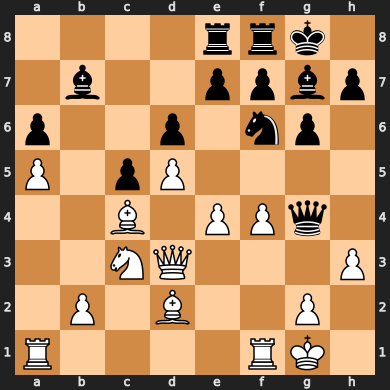

In [64]:
fen = "4rrk1/1b2ppbp/p2p1np1/P1pP4/2B1PPq1/2NQ3P/1P1B2P1/R4RK1 w - - 5 22"
b = chess.Board(fen)
b

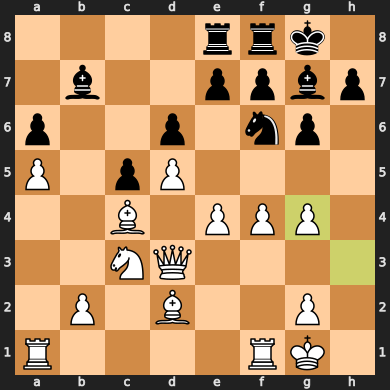

In [65]:
res = MoveMaker(b, 2)
b.push(res[1])
b